In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,concat_ws, collect_list, lit,split, size, avg
from pyspark.sql.window import Window
from pyspark.sql import functions as F

from datasketch import MinHash, MinHashLSH
from sklearn.cluster import KMeans
from numpy import average
import numpy as np 

import shutil
import os
import numpy as np


# All functions used

In [22]:
################################################################################################################################
################################################# Question 1 ###################################################################
################################################################################################################################

def shingle(text, k):
    shingle_set = []
    for i in range(len(text)-k +1):
        shingle_set.append(text[i:i+k])
    return set(shingle_set)

def minhash_lsh(df, k_shingle, threshold):

    lsh = MinHashLSH(threshold=threshold, num_perm=128)
    minhashes = {}

    for features in df.collect():
        shingles = shingle(features["features"], k_shingle)
        m = MinHash(num_perm=128)
        for shingle_item in shingles:
            m.update(shingle_item.encode("utf8"))
        minhashes[int(features["user_id"])] = m
        lsh.insert(int(features["user_id"]), m)

    replacement_candidates = {}
    for key in lsh.keys: 
        replacement_candidates[key] = lsh.query(minhashes[key]) 

    #Key: New representative, value: Similar items
    return replacement_candidates, minhashes

#Iteratively bucket unique processes together
def bucketing(replacement_candidates):
    visited_processes = set()
    new_process_dictionary = {}
    for key, values in replacement_candidates.items():
        new_values = []
        for value in values:
            if value not in visited_processes:
                visited_processes.add(value)
                new_values.append(value)
        if new_values:  # Only add non-empty lists
            new_process_dictionary[key] = sorted(new_values)
    return new_process_dictionary

def show_case(caseID,data):
    data1 = data.filter(data.user_id.isin([caseID]))
    data1.show()

def get_servers(caseID, data):
    data1 = data.filter(data.user_id.isin([caseID]))
    user_id_list = data1.select("to").rdd.flatMap(lambda x: x).collect()
    print(user_id_list)
    
def compare_cases(case1,case2,data):
    data1 = data.filter(data.user_id.isin([case1]))
    data2 = data.filter(data.user_id.isin([case2]))
    desired_column_list1 = data1.select("to").rdd.flatMap(lambda x: x).collect()
    #desired_column_list1
    desired_column_list2 = data2.select("to").rdd.flatMap(lambda x: x).collect()
    #desired_column_list2
    common_elements = np.intersect1d(desired_column_list1, desired_column_list2)
    union_elements = np.union1d(desired_column_list1, desired_column_list2)
    print(len(common_elements)/len(union_elements))


def write_df(df,file_name):
    os.makedirs('Output', exist_ok=True)
    #temporary folder to save all the temporaty files created by write.csv
    os.makedirs('temp', exist_ok=True)
    df.write.csv('temp/temp_outoput', header=True, mode="overwrite")
    part_file = [f for f in os.listdir('temp/temp_outoput') if f.startswith("part-")][0]

    shutil.move(os.path.join('temp/temp_outoput', part_file), file_name)
    shutil.rmtree('temp/temp_outoput')
    shutil.rmtree('temp')

def output_part1(dataset,k,threshold):
    data = spark.read.csv(dataset, header=True, inferSchema=True)
    df = data.withColumn("arrayColumn", concat_ws("","from", "to")).withColumn("Minhash", lit(""))
    df_grouped = df.groupBy("user_id").agg(
                                            concat_ws("",collect_list("arrayColumn")).alias("features"))
    
    replacement_candidates = minhash_lsh(df_grouped,k,threshold)
    new_process_dictionary = bucketing(replacement_candidates)    

    user_ids = list(new_process_dictionary.keys())
    output_df = data.filter(df.user_id.isin(user_ids))
    final_df = output_df.coalesce(1)
    return write_df(final_df,'Output/part1Output.csv')


################################################################################################################################
################################################# Question 2 ###################################################################
################################################################################################################################

def kmeans_clustering(df, n_clusters, max_iter):
    minhashes = []
    #for jaccard verification
    minhash_dict = {}
    user_ids = []
    final_buckets = {}
    for features in df.collect():
        shingles = shingle(features["features"], 5)
        m = MinHash(num_perm=128)
        for shingle_item in shingles:
            m.update(shingle_item.encode("utf8"))
        minhashes.append(m.hashvalues)
        minhash_dict[int(features["user_id"])] = m
        user_ids.append(int(features["user_id"]))

    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter).fit(minhashes)

    user_clusters = dict(zip(user_ids, kmeans.labels_))
    final_buckets = {}
    for key, value in user_clusters.items():
        if value in final_buckets:
            final_buckets[value].append(key)
        else:
            final_buckets[value] = [key]

    return final_buckets, minhash_dict


#Get averege jaccard value per bucket

def get_averege_jaccard_sim(final_buckets, minhashes,get = True):
    sims = {}
    for key, value in final_buckets.items():
        for user_id_1 in final_buckets[key]:
            for user_id_2 in final_buckets[key]:
                if user_id_1 != user_id_2:
                    sig_1 = minhashes[int(user_id_1)]
                    sig_2 = minhashes[int(user_id_2)]
                    sim = MinHash.jaccard(sig_1, sig_2)
                    if key not in sims:
                        sims[key] = [sim]
                    else:
                        sims[key].append(sim)
    total_sum = 0
    total_count = 0
    sims = dict(sorted(sims.items()))
    if get == True:
        for key, value in sims.items():
            avg_sim = average(value)
            print(key, avg_sim)
            total_sum += sum(value)
            total_count += len(value)
        
        overall_average = total_sum / total_count if total_count != 0 else 0
        print("Overall Average Jaccard Similarity:", overall_average)
    else:
        return sims


# Experiments

In [19]:
spark = SparkSession.builder.appName("spark_session_1").getOrCreate()
data = spark.read.csv("data/SDG_dataset2.csv", header=True, inferSchema=True)

df_filtered_m = data.filter(data.type.isin(['Req']))
df_grouped = df_filtered_m.groupBy("user_id").agg(concat_ws("",collect_list("to")).alias("features"))
#data.show()
#df_filtered_m.show()
#df_grouped.show()

## Question 1

### Parameter-tuning for k-shingles

First we're going to see which k is the best for the k-shingles. We gonna do such a thing by investigating how computational expensive it is to compute such minhash for different values of k

k = 3

In [20]:
print(f"Initial number of cases: {df_grouped.count()}")
replacement_candidates3 = minhash_lsh(df_grouped,3,0.98)
new_process_dictionary3 = bucketing(replacement_candidates3)
print(f"After merging cases with threshold 3-shingles: {len(new_process_dictionary3)}")

Initial number of cases: 41833


After merging cases with threshold 3-shingles: 31954


k = 5

In [ ]:
#print(f"Initial number of cases: {df_grouped.count()}")
# replacement_candidates5 = minhash_lsh(df_grouped,5,0.98)
# new_process_dictionary5 = bucketing(replacement_candidates5)
# print(f"After merging cases with threshold 5-shingles: {len(new_process_dictionary5)}")

k = 7

In [ ]:
#print(f"Initial number of cases: {df_grouped.count()}")
# replacement_candidates5 = minhash_lsh(df_grouped,7,0.98)
# new_process_dictionary5 = bucketing(replacement_candidates5)
# print(f"After merging cases with threshold 5-shingles: {len(new_process_dictionary5)}")

k = 9

In [ ]:
#print(f"Initial number of cases: {df_grouped.count()}")
# replacement_candidates5 = minhash_lsh(df_grouped,9,0.98)
# new_process_dictionary5 = bucketing(replacement_candidates5)
# print(f"After merging cases with threshold 5-shingles: {len(new_process_dictionary5)}")

In [62]:
import time
import resource
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws, collect_list, lit
from datasketch import MinHash, MinHashLSH
import shutil
import os
import psutil
import matplotlib.pyplot as plt
import pandas as pd

def average_jaccard_sim(new_process_dictionary, minhashes):
    total_sum = 0
    total_count = 0

    for key, values in new_process_dictionary.items():
        for i in range(len(values)):
            for j in range(i + 1, len(values)):
                sig_1 = minhashes[values[i]]
                sig_2 = minhashes[values[j]]
                sim = sig_1.jaccard(sig_2)
                total_sum += sim
                total_count += 1

    return total_sum / total_count if total_count != 0 else 0

def get_memory_usage(): #memory
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

def get_cpu_usage(): #cpu
    return psutil.cpu_percent(interval=None)

k_values = [2, 3, 4, 5, 6, 7, 8]
results = []

for k in k_values:
    start_time = time.time()
    start_mem = get_memory_usage()
    start_cpu = get_cpu_usage()

    replacement_candidates, minhashes = minhash_lsh(df_grouped, k, 0.98)
    new_process_dictionary = bucketing(replacement_candidates)
    
    end_time = time.time()
    end_mem = get_memory_usage()
    end_cpu = get_cpu_usage()

    duration = end_time - start_time
    avg_jaccard = average_jaccard_sim(new_process_dictionary, minhashes)
    mem_used = end_mem - start_mem

    results.append({
        'k': k,
        'time_seconds': duration,
        'memory_mb': mem_used,
        'unique_processes': len(new_process_dictionary),
        'cpu': end_cpu
    })

    print(f"Results for k={k}:")
    print(f"Time: {duration} seconds")
    print(f"Memory: {mem_used} MB")
    print(f"CPU Percent: {end_cpu}%")
    print(f"Unique Processes: {len(new_process_dictionary)}")
    print(f"Average Jaccard Similarity: {avg_jaccard}")

print("\nSummary of results:")
for result in results:
    print(result)


Results for k=2:
Time: 46.36475396156311 seconds
Memory: 0.0 MB
CPU Percent: 22.2%
Unique Processes: 2839
Average Jaccard Similarity: 0.996801688826587


Results for k=3:
Time: 44.927558183670044 seconds
Memory: 9812.0 MB
CPU Percent: 28.7%
Unique Processes: 31954
Average Jaccard Similarity: 0.9999502062626213
Results for k=4:
Time: 45.257112979888916 seconds
Memory: 100.0 MB
CPU Percent: 18.0%
Unique Processes: 32205
Average Jaccard Similarity: 0.999978414830818
Results for k=5:
Time: 45.34848117828369 seconds
Memory: 0.0 MB
CPU Percent: 17.5%
Unique Processes: 32827
Average Jaccard Similarity: 0.9999868140627494
Results for k=6:
Time: 44.7147581577301 seconds
Memory: 0.0 MB
CPU Percent: 17.1%
Unique Processes: 32840
Average Jaccard Similarity: 0.9999937171565558
Results for k=7:
Time: 44.9187548160553 seconds
Memory: 0.0 MB
CPU Percent: 17.8%
Unique Processes: 32834
Average Jaccard Similarity: 0.9999957553165861
Results for k=8:
Time: 44.33317232131958 seconds
Memory: 0.0 MB
CPU Percent: 18.9%
Unique Processes: 32849
Average Jaccard Similarity: 0.9999963154818965

Summary of results:
{'k': 2, 'time_seconds': 46.36475396156311, 'memory

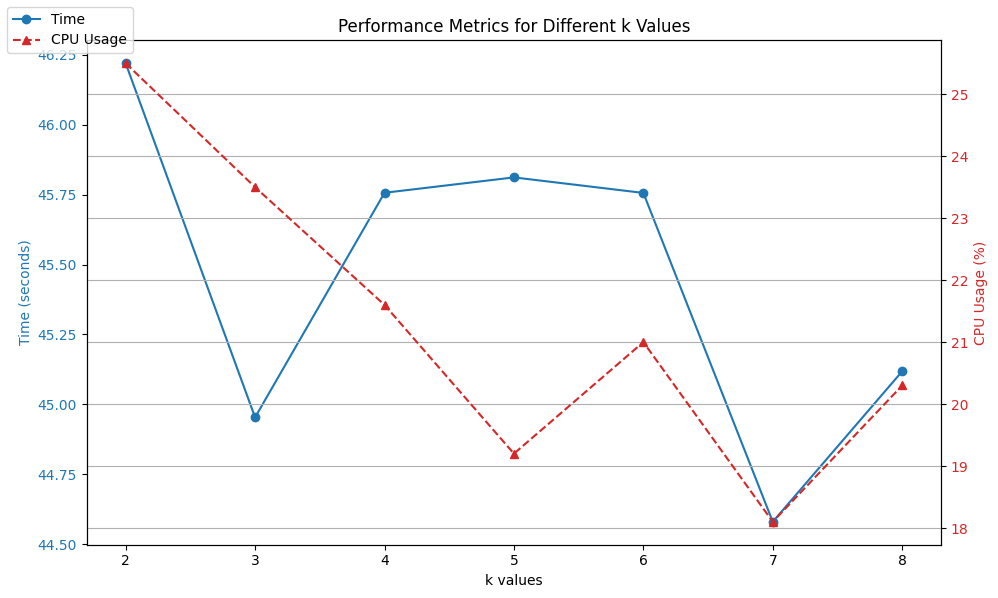

In [61]:
import matplotlib.pyplot as plt

# Data from your results
results = [
    {'k': 2, 'time_seconds': 46.22001576423645, 'memory_mb': 0.0,'cpu': 25.5},
    {'k': 3, 'time_seconds': 44.95308208465576, 'memory_mb': 0.0, 'cpu': 23.5},
    {'k': 4, 'time_seconds': 45.75661110877991, 'memory_mb': 0.0, 'cpu': 21.6},
    {'k': 5, 'time_seconds': 45.81163787841797, 'memory_mb': 0.0, 'cpu': 19.2},
    {'k': 6, 'time_seconds': 45.756104946136475, 'memory_mb': 0.0, 'cpu': 21.0},
    {'k': 7, 'time_seconds': 44.57948970794678, 'memory_mb': 0.0, 'cpu': 18.1},
    {'k': 8, 'time_seconds': 45.117955684661865, 'memory_mb': 0.0, 'cpu': 20.3}
]

k_values = [result['k'] for result in results]
time_seconds = [result['time_seconds'] for result in results]
cpu_percentages = [result['cpu'] for result in results]
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('k values')
ax1.set_ylabel('Time (seconds)', color='tab:blue')
ax1.plot(k_values, time_seconds, marker='o', color='tab:blue', label='Time')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('CPU Usage (%)', color='tab:red')

ax2.plot(k_values, cpu_percentages, marker='^', color='tab:red', linestyle='--', label='CPU Usage')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Performance Metrics for Different k Values')
fig.legend(loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


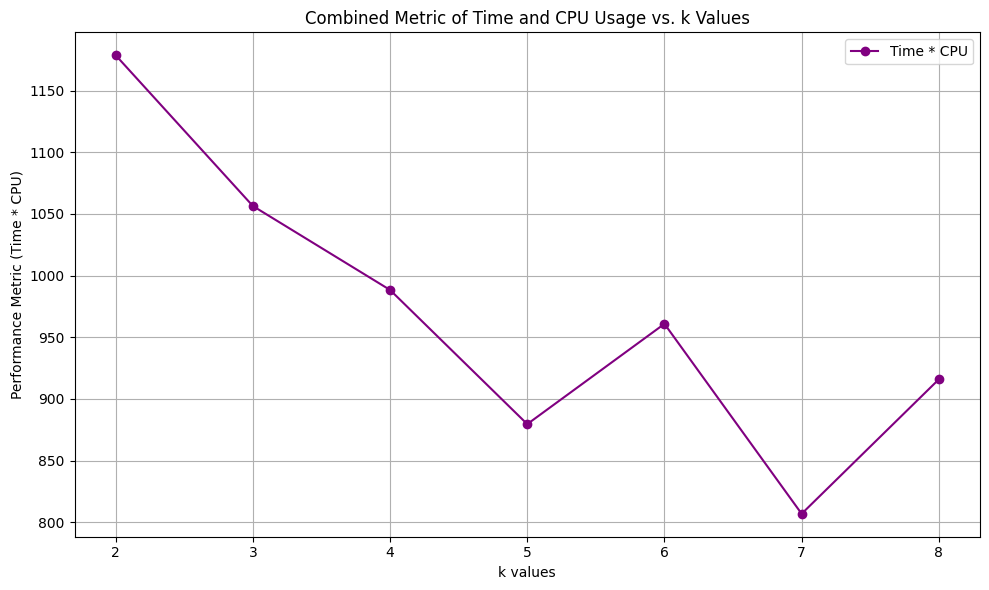

In [60]:
k_values = [result['k'] for result in results]
time_seconds = [result['time_seconds'] for result in results]
cpu_percentages = [result['cpu'] for result in results]

# Calculate the performance metric (Product of time_seconds and cpu)
performance_metric = [time_seconds[i] * cpu_percentages[i] for i in range(len(results))]

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot the performance metric
plt.plot(k_values, performance_metric, marker='o', linestyle='-', color='purple', label='Time * CPU')

# Set labels and title
plt.xlabel('k values')
plt.ylabel('Performance Metric (Time * CPU)')
plt.title('Combined Metric of Time and CPU Usage vs. k Values')
plt.xticks(k_values)
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Hugo investigate graph output

In [ ]:
# import time
# import psutil
# import matplotlib.pyplot as plt

# # Function to measure execution time and resource usage
# def measure_performance(func, *args, **kwargs):
#     start_time = time.time()
#     process = psutil.Process()
#     start_memory = process.memory_info().rss
#     start_cpu = process.cpu_percent(interval=None)

#     result = func(*args, **kwargs)

#     end_time = time.time()
#     end_memory = process.memory_info().rss
#     end_cpu = process.cpu_percent(interval=None)

#     execution_time = end_time - start_time
#     memory_usage = (end_memory - start_memory) / 1024 / 1024  # Convert to MB
#     cpu_usage = end_cpu - start_cpu

#     return execution_time, memory_usage, cpu_usage, result

# # Example function to test performance
# def example_function(n):
#     total = 0
#     for i in range(n):
#         total += i ** 2
#     return total

# # Measure performance of the example function with a specific input
# specific_input = 1000000
# exec_time, mem_usage, cpu_usage, _ = measure_performance(example_function, specific_input)

# # Plotting the results
# labels = ['Execution Time (s)', 'Memory Usage (MB)', 'CPU Usage (%)']
# values = [exec_time, mem_usage, cpu_usage]

# fig, ax = plt.subplots()
# ax.bar(labels, values, color=['red', 'blue', 'green'])

# for i, v in enumerate(values):
#     ax.text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom')

# plt.title(f'Computational Expense Analysis for input size {specific_input}')
# plt.show()


I need to get a function that compares the execution times, CPU and memory used

### Parameter-tuning for the threshold

In [58]:
df_with_lengths = df_grouped.withColumn("feature_length", size(split(col("features"), "S")))
average_length = df_with_lengths.agg(avg("feature_length")).collect()[0][0]

windowSpec = Window.partitionBy(F.lit(1)).orderBy("feature_length")
df_with_lengths = df_with_lengths.withColumn("row_number", F.row_number().over(windowSpec))
total_count = df_with_lengths.count()

if total_count % 2 == 0:
    median_index1 = total_count // 2
    median_index2 = median_index1 + 1
    median_value = df_with_lengths.filter(col("row_number").isin([median_index1, median_index2])) \
                                  .agg(avg("feature_length")).collect()[0][0]
else:
    median_index = (total_count // 2) + 1
    median_value = df_with_lengths.filter(col("row_number") == median_index) \
                                  .select("feature_length").collect()[0][0]
    
print(f"Average number of requests: {average_length}")
print(f"Median number of requests: {median_value}")

Average number of requests: 12.952429899839839
Median number of requests: 13


Given that both the average and the median are close to 13, which shows that the dataset is symetricly distributed when it comes to how many requests are performed, we gonna assume that two cases have a small variation iif the number of different requests is around 1. To get an approximation of the threshold, we're going to use the resutls shown before, so we assume that 12/13 are the same. Given this, we decided to use a threshold of 95%

In [59]:
print(f"Initial number of cases: {df_grouped.count()}")
ans = minhash_lsh(df_grouped,7,0.93)
replacement_candidates7, minhash_dic = ans[0],ans[1]
new_process_dictionary7= bucketing(replacement_candidates7)
print(f"After merging cases with threshold 7-shingles: {len(new_process_dictionary7)}")

Initial number of cases: 41833
After merging cases with threshold 7-shingles: 32304


In [75]:
sims = get_averege_jaccard_sim(replacement_candidates7, minhash_dic)

6 1.0
7 1.0
10 1.0
12 0.9296875
13 1.0
14 1.0
19 1.0
28 1.0
32 0.96875
37 1.0
48 1.0
52 1.0
53 1.0
57 1.0
61 1.0
66 1.0
71 1.0
74 0.9829545454545454
77 1.0
85 1.0
95 1.0
99 0.953125
100 1.0
103 1.0
107 1.0
110 1.0
111 0.9583333333333334
112 1.0
113 1.0
115 1.0
116 0.9375
117 1.0
119 1.0
123 1.0
126 0.9806547619047619
130 1.0
131 1.0
133 1.0
138 1.0
140 1.0
141 1.0
148 1.0
151 1.0
154 1.0
155 1.0
161 1.0
164 1.0
165 1.0
170 0.9583333333333334
174 1.0
176 1.0
179 1.0
180 1.0
183 1.0
187 1.0
189 0.9296875
194 1.0
199 0.9609375
200 1.0
201 1.0
202 1.0
204 1.0
209 1.0
215 1.0
217 1.0
218 1.0
221 1.0
223 1.0
225 1.0
232 1.0
234 1.0
235 1.0
238 1.0
240 0.9791666666666666
244 1.0
246 1.0
250 1.0
257 1.0
265 0.9505494505494505
267 0.9559294871794872
272 0.962071718931475
276 1.0
281 1.0
283 1.0
284 1.0
288 1.0
290 1.0
291 0.9806547619047619
296 1.0
300 0.9517463235294118
301 1.0
306 1.0
310 1.0
313 0.9635416666666666
315 0.921875
320 1.0
322 1.0
332 0.9739583333333334
333 1.0
334 1.0
336 1.0
34

In [66]:
keys_with_target_value = [key for key, value in sims.items() if value == min(sims.values())]
get_servers(keys_with_target_value[0],data)
get_servers(keys_with_target_value[1],data)

['S0', 'S2', 'S2_2', 'S2', 'S2_1', 'S2', 'S2_4', 'S2', 'S2_3', 'S2', 'S0', 'S6', 'S0', 'null']
['S0', 'S2', 'S2_2', 'S2', 'S2_1', 'S2', 'S2_4', 'S2', 'S2_3', 'S2', 'S0', 'S4', 'S4_1', 'S4', 'S0', 'null']


In [43]:
# import time
# import psutil
# import matplotlib.pyplot as plt

# # Function to measure execution time and resource usage
# def measure_performance(func, *args, **kwargs):
#     start_time = time.time()
#     process = psutil.Process()
#     start_memory = process.memory_info().rss
#     start_cpu = process.cpu_percent(interval=None)

#     result = func(*args, **kwargs)

#     end_time = time.time()
#     end_memory = process.memory_info().rss
#     end_cpu = process.cpu_percent(interval=None)

#     execution_time = end_time - start_time
#     memory_usage = (end_memory - start_memory) / 1024 / 1024  # Convert to MB
#     cpu_usage = end_cpu - start_cpu

#     return execution_time, memory_usage, cpu_usage, result

# # Example function to test performance
# def example_function(n):
#     total = 0
#     for i in range(n):
#         total += i ** 2
#     return total

# # Measure performance of the example function with a specific input
# specific_input = 1000000
# exec_time, mem_usage, cpu_usage, _ = measure_performance(example_function, specific_input)

# # Plotting the results
# labels = ['Execution Time (s)', 'Memory Usage (MB)', 'CPU Usage (%)']
# values = [exec_time, mem_usage, cpu_usage]

# fig, ax = plt.subplots()
# ax.bar(labels, values, color=['red', 'blue', 'green'])

# for i, v in enumerate(values):
#     ax.text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom')

# plt.title(f'Computational Expense Analysis for input size {specific_input}')
# plt.show()


In [76]:
# import time
# import psutil
# import matplotlib.pyplot as plt

# # Function to measure execution time and resource usage
# def measure_performance(func, *args, **kwargs):
#     start_time = time.time()
#     process = psutil.Process()
#     start_memory = process.memory_info().rss
#     start_cpu = process.cpu_percent(interval=None)

#     result = func(*args, **kwargs)

#     end_time = time.time()
#     end_memory = process.memory_info().rss
#     end_cpu = process.cpu_percent(interval=None)

#     execution_time = end_time - start_time
#     memory_usage = (end_memory - start_memory) / 1024 / 1024  # Convert to MB
#     cpu_usage = end_cpu - start_cpu

#     return execution_time, memory_usage, cpu_usage, result

# # Example function to test performance
# def example_function(n):
#     total = 0
#     for i in range(n):
#         total += i ** 2
#     return total

# # Measure performance of the example function with different inputs
# inputs = [10000, 100000, 500000, 1000000]
# times = []
# memories = []
# cpus = []

# for input_val in inputs:
#     exec_time, mem_usage, cpu_usage, _ = measure_performance(example_function, input_val)
#     times.append(exec_time)
#     memories.append(mem_usage)
#     cpus.append(cpu_usage)

# # Plotting the results
# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('Input Size')
# ax1.set_ylabel('Execution Time (s)', color=color)
# ax1.plot(inputs, times, color=color, marker='o', label='Time')
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# color = 'tab:blue'
# ax2.set_ylabel('Memory Usage (MB)', color=color)  # we already handled the x-label with ax1
# ax2.plot(inputs, memories, color=color, marker='x', linestyle='--', label='Memory')
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.title('Computational Expense Analysis')

# # Optional: Add a secondary y-axis for CPU usage
# ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax3.spines['right'].set_position(('outward', 60))  # offset the third axis
# color = 'tab:green'
# ax3.set_ylabel('CPU Usage (%)', color=color)
# ax3.plot(inputs, cpus, color=color, marker='s', linestyle=':', label='CPU')
# ax3.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.title('Computational Expense Analysis')
# plt.show()


In [ ]:
# output_part1("data/SDG_dataset2.csv",3,0.95)
# output_part1("data/SDG_dataset2.csv",5,0.95)
output_part1("data/SDG_dataset2.csv",7,0.95)

# Question 2

## Parameter tuning for Kmeans

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

minhashes = []
user_ids = []
final_buckets = {}
for features in df_grouped.collect():
    shingles = shingle(features["features"], 5)
    m = MinHash(num_perm=128)
    for shingle_item in shingles:
        m.update(shingle_item.encode("utf8"))
    minhashes.append(m.hashvalues)
    user_ids.append(int(features["user_id"]))

param_grid = {
    'n_clusters': [100, 250, 500],
    'max_iter': [100, 500, 1000],
}

kmeans = KMeans()

grid_search = GridSearchCV(kmeans, param_grid, cv=5)

grid_search.fit(minhashes)

best_param = grid_search.best_params_
best_model = grid_search.best_estimator_

print("The best parameters are: " , best_param )
print("The best model is: ", best_model)

KeyboardInterrupt: 

24/06/23 02:41:15 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 7211405 ms exceeds timeout 120000 ms
24/06/23 02:41:15 WARN SparkContext: Killing executors is not supported by current scheduler.
24/06/23 02:41:15 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 

## STEP 1: Find and merge

In [46]:
replacement_candidates = minhash_lsh(df_grouped,5,0.7)
new_process_dictionary = bucketing(replacement_candidates)
print(len(replacement_candidates))
print(len(new_process_dictionary))

41833
11381


## STEP 2: Find/cluster similar items

In [47]:
#from sklearn.model_selection import train_test_split, GridSearchCV

users = []
for key in new_process_dictionary:
    users.append(key)

filtered_df = df_grouped[df_grouped['user_id'].isin(users)]

final_buckets, minhashes = kmeans_clustering(filtered_df,500,100)

In [49]:
#final_buckets #
minhashes  #

{1: <datasketch.minhash.MinHash at 0x7fc769ff2d30>,
 3: <datasketch.minhash.MinHash at 0x7fc71195b880>,
 5: <datasketch.minhash.MinHash at 0x7fc71195ba90>,
 9: <datasketch.minhash.MinHash at 0x7fc7117fe370>,
 12: <datasketch.minhash.MinHash at 0x7fc7117fe3d0>,
 15: <datasketch.minhash.MinHash at 0x7fc7112b3a60>,
 16: <datasketch.minhash.MinHash at 0x7fc7112b3af0>,
 17: <datasketch.minhash.MinHash at 0x7fc7112b3b50>,
 20: <datasketch.minhash.MinHash at 0x7fc7112b3bb0>,
 22: <datasketch.minhash.MinHash at 0x7fc7112b3c10>,
 26: <datasketch.minhash.MinHash at 0x7fc7112b3c70>,
 27: <datasketch.minhash.MinHash at 0x7fc7112b3cd0>,
 28: <datasketch.minhash.MinHash at 0x7fc7112b3d30>,
 31: <datasketch.minhash.MinHash at 0x7fc7112b3d90>,
 34: <datasketch.minhash.MinHash at 0x7fc7112b3df0>,
 37: <datasketch.minhash.MinHash at 0x7fc7112b3e50>,
 38: <datasketch.minhash.MinHash at 0x7fc7112b3f10>,
 44: <datasketch.minhash.MinHash at 0x7fc7112b3ee0>,
 47: <datasketch.minhash.MinHash at 0x7fc7112b3f70

## Verification

In [ ]:
get_averege_jaccard_sim(final_buckets, minhashes)

In [ ]:
# indexer = StringIndexer(inputCol="features", outputCol="from_to_type_index")
# indexed_data = indexer.fit(actual_routes_feature).transform(actual_routes_feature)
# assembler = VectorAssembler(inputCols=["from_to_type_index"], outputCol="vector")
# actual_feature_data = assembler.transform(indexed_data)

# actual_feature_data.show()
# # def is_non_zero_vector(vector):
# #     return vector.numNonzeros() > 0

# # is_non_zero_vector_udf = udf(is_non_zero_vector, BooleanType())

# # filtered_data = actual_feature_data.filter(is_non_zero_vector_udf(col("vector")))


# mh = MinHashLSH(inputCol="vector", outputCol="hashes", numHashTables=5, seed=1003)
# model = mh.fit(actual_feature_data)

# #transformed_filtered_data = model.transform(actual_feature_data).head()
# test = model.approxNearestNeighbors()

# # transformed_filtered_data.show(truncate=False, n=50)


# #similar_items.show(truncate=False)

# def is_non_zero_vector(vector):
#     return vector.numNonzeros() > 0

# from collections import defaultdict

# representative_mapping = {}

# group_mapping = defaultdict(list)

# # Iterate over the user neighbors dictionary
# for user, neighbors in new_process_dictionary.items():
#     neighbors_sorted = tuple(sorted(neighbors))
#     if neighbors_sorted in representative_mapping:
#         representative = representative_mapping[neighbors_sorted]
#     else:
#         representative = neighbors_sorted[0]
#         for neighbor in neighbors_sorted:
#             representative_mapping[neighbor] = representative
    
#     representative_mapping[user] = representative
#     group_mapping[representative].append(user)

# new_user_neighbors = {}
# for representative, users in group_mapping.items():
#     new_user_neighbors[representative] = users

# #print(new_user_neighbors)
# new_users = []
# for key, value in new_user_neighbors.items():
#     new_users.append(key)

# print(len(new_users))
# filtered_df = df_grouped[df_grouped['user_id'].isin(new_users)]
# print(f"Amount of processes: {filtered_df.count()}")
#     shingles = shingle(features["features"], 5)
#     m = MinHash(num_perm=128)
#     for shingle_item in shingles:
#         m.update(shingle_item.encode("utf8"))
#     minhashes[int(features["user_id"])] = m
#     lsh.insert(int(features["user_id"]), m)
#     neigbours = lsh.query(m)
#     print(features["user_id"], neigbours)
#     final_buckets[features["user_id"]] = neigbours

# print(final_buckets)